see: https://github.com/87surendra/Random-Forest-Image-Classification-using-Python/blob/master/Random-Forest-Image-Classification-using-Python.ipynb

In [1]:
import os
import cv2
import h5py
import glob
import mahotas

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# make a fix file size
fixed_size  = tuple((224,224))

#train path 
train_path = os.path.join('..', 'storage', 'binary_classification', 'pizza_steak', 'train')
test_path = os.path.join('..', 'storage', 'binary_classification', 'pizza_steak', 'test')
model_path = os.path.join('..', 'storage', 'models')

# no of trees for Random Forests
num_tree = 100

# bins for histograms 
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same result 
seed = 9 

In [3]:
# features description -1:  Hu Moments

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [4]:
# feature-descriptor -2 Haralick Texture 

def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    
    return haralic

In [5]:
# feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    
    # normalize the histogram
    cv2.normalize(hist,hist)
    
    # return the histog....
    return hist.flatten()

## Loop inside the folder for train images

In [6]:
# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0

# num of images per class 
images_per_class = 80

for training_name in os.listdir(train_path):
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
    for file in os.listdir(dir):
        file = f'{dir}/{os.fsdecode(file)}'
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        if image is not None:
            image = cv2.resize(image,fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)
        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1
    
print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: pizza
[STATUS] processed folder: steak
[STATUS] completed Global Feature Extraction...


In [7]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1500, 532)


In [8]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (1500,)


In [9]:
# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")

[STATUS] training labels encoded...{}


In [10]:
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [12]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (1500,)


In [13]:
# save the feature vector using HDF5
h5f_data = h5py.File(f'{model_path}/random_forest_classifier_model.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(f'{model_path}/random_forest_classifier_labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [14]:
# import the feature vector and trained labels
h5f_data = h5py.File(f'{model_path}/random_forest_classifier_model.h5', 'r+')
h5f_label = h5py.File(f'{model_path}/random_forest_classifier_labels.h5', 'r+')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

In [15]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

In [16]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

#print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(trainDataGlobal)

clf_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:

#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
print(classification_report(trainLabelsGlobal,clf_pred))
#print(clf.predict(trainDataGlobal))
#print(clf.predict(global_feature.reshape(1,-1))[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       685
           1       1.00      1.00      1.00       665

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350



In [18]:
print(confusion_matrix(trainLabelsGlobal,clf_pred))

[[685   0]
 [  0 665]]


In [19]:
# Let' visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


def view_random_image(target_dir, target_class):
    # set the target directory (we'll view all images from here)
    # target_folder = target_dir + target_class

    # get a random image path
    random_image = random.sample(os.listdir(f'{target_dir}/{target_class}'), 1)

    # read in the image and plot it using matplotlib
    # img = mpimg.imread(os.path.join(target_dir, target_class, random_image[0]))
    
    img = cv2.imread(os.path.join(target_dir, target_class, random_image[0]))
    img_resize = cv2.resize(img, fixed_size)
    
    # plt.imshow(img)
    # plt.title(target_class)
    # plt.axis('off')

    # print(f'image shape: {img.shape}')  # show the shape of the image
    return img_resize

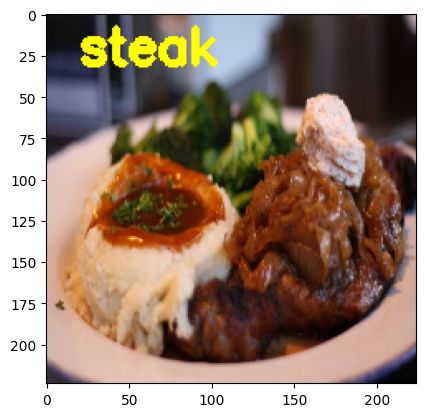

In [24]:
image = view_random_image(target_dir=f'{test_path}', target_class='steak')

fv_hu_moments = fd_hu_moments(image)
fv_haralick   = fd_haralick(image)
fv_histogram  = fd_histogram(image)

# Concatenate global features
global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

# predict label of test image
prediction = clf.predict(global_feature.reshape(1,-1))[0]

# show predicted label on image
cv2.putText(image, os.listdir(train_path)[prediction], (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 3)

# display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()